# **Практическая работа №6. Проектирование автоэнкодеров для решения прикладных задач**

[**Ссылка на код с пары**](https://colab.research.google.com/drive/1KfCEQly5k0PUdCR1w-my2-QmYfFexdvK?usp=sharing)

# Задание №1. Реализуйте автоэнкодер для колоризации чёрно-белых изображений

* **Чем больше объектов разных классов будет в исходном датасете, тем универсальнее будет работа обученной Вами модели**

> Например, если в Вашем датасете только кошки, то все объекты кроме кошек будут колоризоваться некорректно. Соответственно следует очень тщательно подойти к выбору датасета. 

  * Для решения данной задачи может подойти датасет [CIFAR-100](https://www.kaggle.com/datasets/fedesoriano/cifar100), но его минус заключается в том, что разрешение изображений довольно низкое

* Хорошим вариантом будет использование датасета [ImageNet](https://paperswithcode.com/dataset/imagenet), но ввиду его объёмности, процесс обучения займет большое количество времени, поэтому Вы можете использовать одну из его [сокращенных версий](https://www.kaggle.com/datasets/ifigotin/imagenetmini-1000)

 **Конечный выбор датасета осуществляется по Вашему желанию, учитывая рекомендации приведенные выше.**


Был выбран датасет ImageNet. Используется его фрагмент - ~~`134 454`~~ `4001` изображений. Было создано 2 директории.
- `train_images_0_rs` - цветные картинки размерами 224x224;
- `train_images_0_bw` - черно-белые картинки размерами 224x224

Пропишем импорты

In [211]:
# Поток загрузки картинок и генерации их вариаций
from keras.preprocessing.image import ImageDataGenerator

# Вывод всех путей картинок для расчета количества батчей на эпоху
from imutils.paths import list_images

# Загрузка картинок в формате PIL
from tensorflow.keras.utils import img_to_array, load_img

# Перевод картинок в другой формат
from skimage.color import rgb2lab, lab2rgb, gray2rgb, rgb2gray

# Используемая предобученная модель
from tensorflow.keras.applications import VGG16

# Слои для проектирования своей модели
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, UpSampling2D
from tensorflow.keras.optimizers import Adamax

# Операции над картинками
import cv2

# Отображение графиков
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# NumPy
import numpy as np

# Нормальное отображение прогресса обучения нейронной сети без излишнего вывода
from tqdm.keras import TqdmCallback

# Проверка работоспособности GPU
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13098254829599580916,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5717884928
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15443869597598897199
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:02:00.0, compute capability: 8.6"]

Создадим поток из данных

In [212]:
seed=24
batch_size=100

source_img_path = r".\train_images_0_bw"
target_img_path = r".\train_images_0_rs"

In [213]:
encoder = VGG16(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)
encoder.trainable = False
encoder.summary()

autoencoder = Sequential()
autoencoder.add(encoder)
autoencoder.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
autoencoder.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
autoencoder.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((4, 4)))
autoencoder.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
autoencoder.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
autoencoder.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((4, 4)))
autoencoder.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))

autoencoder.summary()
autoencoder.compile(optimizer=Adamax(0.001), loss='mse', metrics=['accuracy'])

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

С использованием генераторов. 4000 картинок

In [214]:
def preprocess_data(image, target):
    lab = rgb2lab(image)
    X = lab[:,:,:,0]
    Y = lab[:,:,:,1:]
    
    X = gray2rgb(X)
    
    X = np.array(X) / 256.0
    Y = np.array(Y) / 196.0
    
    return (X, Y)

In [215]:
def rgb_to_lab2ch(color_image):
    lab = rgb2lab(color_image)
    lab2ch = lab[:,:,1:]
    
    return lab2ch

In [216]:
def lab2ch_to_rgb(grayscale_image, ab):
    lab = rgb2lab(grayscale_image)
    l = lab[:,:,0]
    
    restored_lab_img = np.zeros((224, 224, 3))
    
    restored_lab_img[:,:,0] = l
    restored_lab_img[:,:,1:] = ab
    
    restored_color_img = lab2rgb(restored_lab_img)
    
    return restored_color_img

In [217]:
def trainGenerator(train_img_path, train_target_path):   
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True)
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        color_mode='rgb',
        target_size=(224, 224),
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    target_datagen = ImageDataGenerator(**img_data_gen_args)
    target_generator = target_datagen.flow_from_directory(
        train_target_path,
        color_mode='grayscale',
        target_size=(224, 224),
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    train_generator = zip(image_generator, target_generator)
    
    count = 0
    
    for (img, target) in train_generator:
        processed_img, processed_target = preprocess_data(img, target)
        
        count += 1
        if count < 200:
            yield (processed_img, processed_target)
        else:
            return (processed_img, processed_target)

In [218]:
trainGen = trainGenerator(
    source_img_path,
    target_img_path
)

batch_count = len(list(list_images(source_img_path))) // batch_size
print(f'Batches per epoch: {batch_count}')

Batches per epoch: 40


In [85]:
history = autoencoder.fit(
    trainGen,
    steps_per_epoch=batch_count,
    batch_size=batch_size,
    epochs=1,
    verbose=0,
    callbacks=[TqdmCallback(verbose=1)]
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Found 4001 images belonging to 1 classes.
Found 4001 images belonging to 1 classes.


Без генераторов. 200 картинок

### Загрузка картинок без генератора

In [193]:
# from tqdm import tqdm
# from sklearn.model_selection import train_test_split
# import random
# from imutils import paths

# source_paths = sorted(list(list_images(source_img_path)))
# target_paths = sorted(list(list_images(target_img_path)))

# data = []
# targets = []

# count = 0

# for source_path, target_path in tqdm(zip(source_paths, target_paths), total=200, position=0):
#     source_gray = cv2.imread(source_path)
#     #source_gray = preprocess_input(source_gray)
    
#     target_color = cv2.cvtColor(
#         cv2.imread(target_path), 
#         cv2.COLOR_BGR2RGB 
#     )
#     target_lab_ab = rgb_to_lab2ch(target_color)
    
    
#     data.append(source_gray)
#     targets.append(target_lab_ab)

#     count += 1
#     if count > 200:
#         break

# print("Normalizing data...")
# data = np.array(data, dtype='float32') / 256.0
# targets = np.array(targets, dtype='float32') / 128.0
# print("Splitting data...")
# (trainX, testX, trainY, testY) = train_test_split(data, targets, test_size=0.25, random_state=42)

# print("Done")
# print("Shapes:")
# print(f'trainX: {trainX.shape}')
# print(f'trainY: {trainY.shape}')
# print(f'testX: {testX.shape}')
# print(f'testY: {testY.shape}')

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 40.74it/s]


Normalizing data...
Splitting data...
Done
Shapes:
trainX: (150, 224, 224, 3)
trainY: (150, 224, 224, 2)
testX: (51, 224, 224, 3)
testY: (51, 224, 224, 2)


In [194]:
# print(np.max(trainX))
# print(np.max(trainY))
# print(np.max(testX))
# print(np.max(testY))

0.99609375
0.9348038
0.99609375
0.96002394


In [196]:
# history = autoencoder.fit(
#     trainX, 
#     trainY, 
#     validation_data=(testX, testY), 
#     epochs=50, 
#     batch_size=150, 
#     verbose=0, 
#     callbacks=[TqdmCallback(verbose=1)]
# )

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [ ]:
history = autoencoder.fit(
    trainGen,
    steps_per_epoch=batch_count,
    batch_size=batch_size,
    epochs=100,
    verbose=0,
    callbacks=[TqdmCallback(verbose=1)]
)

In [181]:
autoencoder.save("autoencoder_vgg16_exp_50.h5", save_format="h5")

### Список обученных моделей

In [202]:
import os

def find_h5_files(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".h5"):
                print(file)

find_h5_files(os.getcwd())

autoencoder.h5
autoencoder_100.h5
autoencoder_resnet50v2_300.h5
autoencoder_vgg16.h5
autoencoder_vgg16_50.h5
autoencoder_vgg16_exp_50.h5
autoencoder_vgg16_gen4000_1.h5
autoencoder_vgg19_gen4000_50.h5
upscale_resnet50v2_20_gen2000.h5
upscale_vgg16_20_gen2000.h5
watermark_resnset50v2_50_gen4000.h5
watermark_vgg16_2_50_gen4000.h5
watermark_vgg16_50_gen4000.h5


### Тест моделей

In [228]:
from keras import models
autoencoder = models.load_model("autoencoder_resnet50v2_300.h5")

In [226]:
def predict(imagePath, autoencoder):
    original = cv2.cvtColor(
        cv2.imread(imagePath),
        cv2.COLOR_BGR2RGB
    )
    
    grayscale = cv2.cvtColor(
        original.copy(),
        cv2.COLOR_RGB2GRAY
    )
    grayscale_rgb = gray2rgb(grayscale)
    prepr_enc_input = grayscale_rgb / 256.0
    prepr_enc_input = np.reshape(prepr_enc_input, (1, 224, 224, 3))
    ab = autoencoder.predict(prepr_enc_input)
    ab *= 128
    #print(ab)
    restored_rgb = lab2ch_to_rgb(grayscale_rgb, ab)
    
    orig_ab = rgb_to_lab2ch(original)
    lab2rgb_test = lab2ch_to_rgb(grayscale_rgb, orig_ab)
    
    plt.figure()
    
    orig_plt = plt.subplot(1, 3, 1)
    orig_plt.imshow(original)
    orig_plt.set_title("Original")
    orig_plt.axis("off")
    
    rgb_plt = plt.subplot(1, 3, 2)
    rgb_plt.imshow(grayscale_rgb)
    rgb_plt.set_title("Grayscale")
    rgb_plt.axis("off")
    
    rgb_plt = plt.subplot(1, 3, 3)
    rgb_plt.imshow(restored_rgb)
    rgb_plt.set_title("RGB predicted")
    rgb_plt.axis("off")

C:\Users\flexl\AppData\Local\Temp\ipykernel_16088\1379233209.py:10: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 597 negative Z values that have been clipped to zero
  restored_color_img = lab2rgb(restored_lab_img)
C:\Users\flexl\AppData\Local\Temp\ipykernel_16088\1379233209.py:10: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2486 negative Z values that have been clipped to zero
  restored_color_img = lab2rgb(restored_lab_img)
C:\Users\flexl\AppData\Local\Temp\ipykernel_16088\1379233209.py:10: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 519 negative Z values that have been clipped to zero
  restored_color_img = lab2rgb(restored_lab_img)
C:\Users\flexl\AppData\Local\Temp\ipykernel_16088\1379233209.py:10: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 277 negative Z values that have been clipped to zero
  restored_color_img = lab2rgb(restored_lab_img)
C:\User

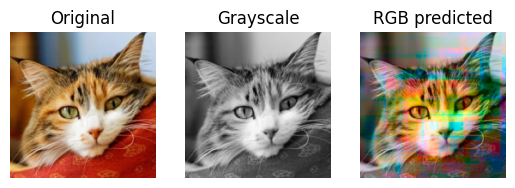

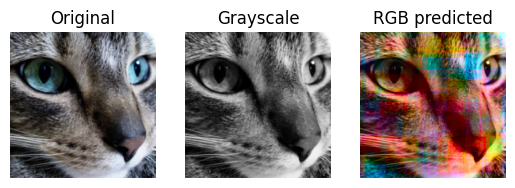

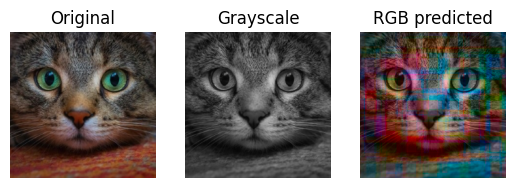

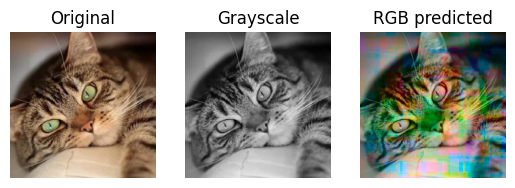

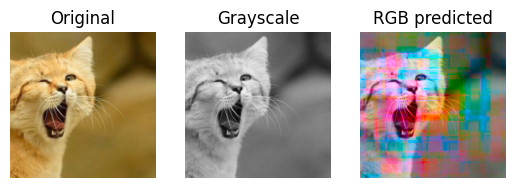

In [229]:
from imutils import paths
imagePaths = sorted(list(list_images(r"./test_images_0")))
for imagePath in imagePaths:
    predict(imagePath, autoencoder)

# Задание №2. Реализуйте автоэнкодер для удаления шума на однотипных изображениях

1.  Подберите датасет, состоящий из однотипных изображений, которые в реальной жизни часто подвержены зашумлению, например спутниковые снимки, ночные фотографии и т.д.

2.  Затем примените к ним операцию зашумления и обучите модель. Также учитывайте тип шума, который Вы применяете. Он должен быть приближен к естественному.

Хороший пример реализации подобной задачи: https://www.kaggle.com/code/michalbrezk/denoise-images-using-autoencoders-tf-keras

In [88]:
# Поток загрузки картинок и генерации их вариаций
from keras.preprocessing.image import ImageDataGenerator

# Вывод всех путей картинок для расчета количества батчей на эпоху
from imutils.paths import list_images

# Используемая предобученная модель
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

# Слои для проектирования своей модели
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.optimizers import Adamax

# NumPy
import numpy as np

# Операции над картинками
import cv2

# Отображение графиков
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Нормальное отображение прогресса обучения нейронной сети без излишнего вывода
from tqdm.keras import TqdmCallback

# Проверка работоспособности GPU
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9571449440182728367,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5717884928
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4334236522759629921
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:02:00.0, compute capability: 8.6"]

In [157]:
seed=24
batch_size=32

source_img_path = r".\train_images_1_train"
target_img_path = r".\train_images_1_target"

In [156]:
def preprocess_data(source, target):
    source = preprocess_input(source)
    
    source = source.astype('float32') / 255.0
    target = target.astype('float32') / 255.0
    
    return (source, target)

In [155]:
def trainGenerator(train_img_path, train_target_path):   
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True)
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        color_mode='rgb',
        target_size=(224, 224),
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    target_datagen = ImageDataGenerator(**img_data_gen_args)
    target_generator = target_datagen.flow_from_directory(
        train_target_path,
        color_mode='rgb',
        target_size=(224, 224),
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    train_generator = zip(image_generator, target_generator)
    
    for (img, target) in train_generator:
        processed_img, processed_target = preprocess_data(img, target)
        yield (processed_img, processed_target)

In [149]:
encoder = VGG16(
    input_shape=(224, 224, 3),
    include_top=False
)
encoder.trainable = False

autoencoder = Sequential()
autoencoder.add(encoder)
autoencoder.add(Conv2DTranspose(1024, (3, 3), strides=2, activation="relu", padding="same"))
autoencoder.add(Conv2DTranspose(512, (3, 3), strides=2, activation="relu", padding="same"))
autoencoder.add(Conv2DTranspose(256, (3, 3), strides=2, activation="relu", padding="same"))
autoencoder.add(Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same"))
autoencoder.add(Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same"))
autoencoder.add(Conv2DTranspose(3, (2, 2), activation='relu', padding='same'))

autoencoder.summary()
autoencoder.compile(optimizer=Adamax(0.001), loss='mse', metrics=['accuracy'])

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
conv2d_transpose_56 (Conv2DT (None, 14, 14, 1024)      4719616   
_________________________________________________________________
conv2d_transpose_57 (Conv2DT (None, 28, 28, 512)       4719104   
_________________________________________________________________
conv2d_transpose_58 (Conv2DT (None, 56, 56, 256)       1179904   
_________________________________________________________________
conv2d_transpose_59 (Conv2DT (None, 112, 112, 128)     295040    
_________________________________________________________________
conv2d_transpose_60 (Conv2DT (None, 224, 224, 64)      73792     
_________________________________________________________________
conv2d_transpose_61 (Conv2DT (None, 224, 224, 3)     

In [158]:
trainGen = trainGenerator(
    source_img_path,
    target_img_path
)

batch_count = len(list(list_images(source_img_path))) // batch_size
print(f'Batches per epoch: {batch_count}')

Batches per epoch: 125


In [159]:
trainX, trainY = next(trainGen)
print(trainX.shape)
print(trainY.shape)

Found 4001 images belonging to 1 classes.
Found 4001 images belonging to 1 classes.
(32, 224, 224, 3)
(32, 224, 224, 3)


In [ ]:
history = autoencoder.fit(
    trainGen,
    steps_per_epoch=batch_count,
    batch_size=batch_size,
    epochs=50,
    verbose=0,
    callbacks=[TqdmCallback(verbose=1)]
)

In [20]:
autoencoder.save("watermark_vgg16_2_150_gen4000.h5", save_format="h5")

### Список доступых моделей

In [33]:
import os

def find_h5_files(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".h5"):
                print(file)

find_h5_files(os.getcwd())

autoencoder_resnet50v2_300.h5
upscale_vgg16_1_gen2000.h5
upscale_vgg16_2_gen2000.h5
upscale_vgg16_4_150_gen2000.h5
watermark_vgg16_50_gen4000.h5


### Тест моделей

In [132]:
def predict(imagePath, autoencoder):
    watermark = cv2.imread(imagePath)
    watermark_prep = watermark / 256.0
    watermark_prep = np.reshape(watermark_prep, (1, 224, 224, 3))
    cleaned_img = autoencoder.predict(watermark_prep)
    plt.figure()
    
    orig_plt = plt.subplot(1, 2, 1)
    orig_plt.imshow(cv2.cvtColor(watermark, cv2.COLOR_BGR2RGB))
    orig_plt.set_title("Watermark")
    orig_plt.axis("off")
    
    rgb_plt = plt.subplot(1, 2, 2)
    rgb_plt.imshow(cleaned_img[0])
    rgb_plt.set_title("Cleaned image")
    rgb_plt.axis("off")

In [134]:
from keras import models
autoencoder = models.load_model("watermark_vgg16_50_gen4000.h5")

In [ ]:
autoencoder.summary()

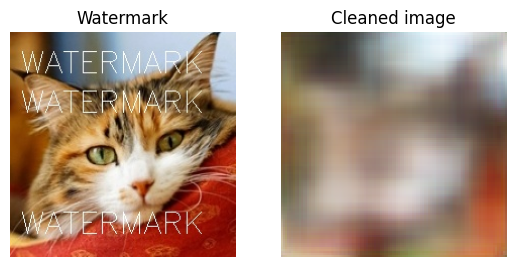

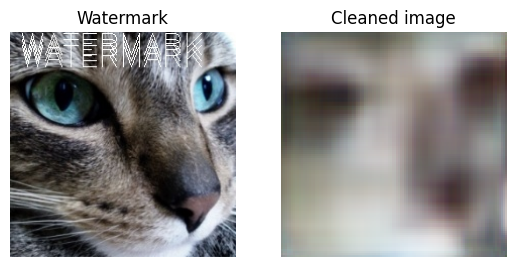

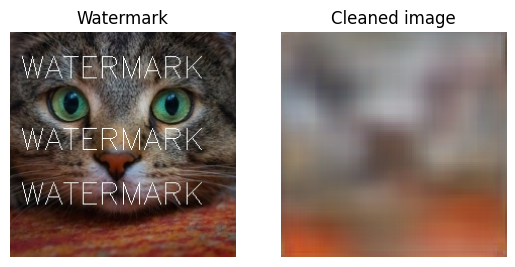

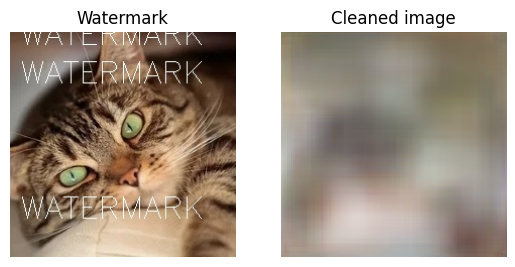

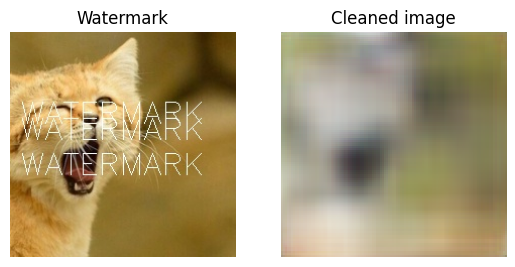

In [135]:
from imutils import paths
imagePaths = sorted(list(list_images(r"./test_images_1")))
for imagePath in imagePaths:
    predict(imagePath, autoencoder)

# Задание №.3 Реализуйте автоэнкодер для улучшения качества изображения путём увеличения его разрешения (аскейлинг-[определение](https://dic.academic.ru/dic.nsf/ruwiki/346555))

1. На входной слой нейронной сети подаётся изображение с размерностью (256, 256,3) - X_test. В результате работы нейронной сети на выходном слое должно получиться изображение (512, 512, 3) - Y_test. В итоге мы получаем двукратный апскейл исходного изображения.

2. Датасет собираете из изображений, разрешение которых выше эталонного (512,512,3). Затем преобразуете их в указанные размерности и формируете из них обучающую и проверочную выборку. 

3. Подумайте, каким образом можно будет адаптировать модель вашей нейронной сети для двухратного апскейла изображения с любой размерностью, большей, чем (256,256,3), с полным или частичным сохранением его исходных пропорций. Например: подаём на вход изображение с разрешением (1920, 1080, 3) - получаем изображение с разрешением (3840, 2160, 3), т.е. с полным сохранением исходных пропорций или (1792, 1024, 3) с частичным сохранением исходных пропорций.

> Подсказка: Для этого нужно реализовать алгоритм предварительной обработки исходного изображения, перед подачей его в нейронную сеть

In [10]:
# Поток загрузки картинок и генерации их вариаций
from keras.preprocessing.image import ImageDataGenerator

# Вывод всех путей картинок для расчета количества батчей на эпоху
from imutils.paths import list_images

# Создание отсутствующих путей
from pathlib import Path

# Используемая предобученная модель
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

# Слои для проектирования своей модели
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, BatchNormalization
from tensorflow.keras.optimizers import Adamax

# NumPy
import numpy as np

# Для обработки изображений
import cv2

# Отображение графиков
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Нормальное отображение прогресса обучения нейронной сети без излишнего вывода
from tqdm.keras import TqdmCallback

# Проверка работоспособности GPU
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8106142934276357398
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5717884928
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2591364494776840743
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:02:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [12]:
seed=24
batch_size=20

train_dataset_path = 'dataset2\\train'
val_dataset_path = 'dataset2\\val'

In [13]:
def preprocess_data(source, target):
    source = preprocess_input(source)
    
    source = source.astype('float32') / 255.0
    target = target.astype('float32') / 255.0
    
    return (source, target)

In [14]:
def trainGenerator(train_path):   
    train_img_path = train_path + '\\' + 'train'
    train_target_path = train_path + '\\' + 'target'
    
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True)
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        color_mode='rgb',
        target_size=(256, 256),
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    target_datagen = ImageDataGenerator(**img_data_gen_args)
    target_generator = target_datagen.flow_from_directory(
        train_target_path,
        color_mode='rgb',
        target_size=(512, 512),
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    train_generator = zip(image_generator, target_generator)
    
    for (img, target) in train_generator:
        processed_img, processed_target = preprocess_data(img, target)
        yield (processed_img, processed_target)

In [24]:
train_gen = trainGenerator(train_dataset_path)
val_gen = trainGenerator(val_dataset_path)

train_steps_count = len(list(list_images(train_dataset_path + '\\' + 'train'))) // batch_size
val_steps_count = len(list(list_images(val_dataset_path + '\\' + 'train'))) // batch_size
print(f'Train steps per epoch: {train_steps_count}')
print(f'Val steps per epoch: {val_steps_count}')

Train steps per epoch: 74
Val steps per epoch: 25


In [25]:
encoder = VGG16(
    input_shape=(256, 256, 3),
    include_top=False
)
encoder.trainable = False

autoencoder = Sequential()
autoencoder.add(encoder)
autoencoder.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((4, 4)))
autoencoder.add(BatchNormalization())
autoencoder.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((4, 4)))
autoencoder.add(BatchNormalization())
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((4, 4)))
autoencoder.add(BatchNormalization())
autoencoder.add(Conv2D(3, (3, 3), activation='relu', padding='same'))

autoencoder.summary()
autoencoder.compile(optimizer=Adamax(0.001), loss='mse', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 256)         1179904   
                                                                 
 up_sampling2d_3 (UpSampling  (None, 32, 32, 256)      0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 32, 32, 256)      1024      
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        147520    
                                                                 
 up_sampling2d_4 (UpSampling  (None, 128, 128, 64)    

In [26]:
from tqdm.keras import TqdmCallback
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger, BackupAndRestore

# Создать директорию для бэкапов модели
backup_dir = 'tmp/backup'
Path(backup_dir).mkdir(parents=True, exist_ok=True)

my_callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, verbose=1),
    #ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=0, min_lr=0.0001),
    BackupAndRestore(backup_dir),
    CSVLogger("upscale_vgg16_2_gen2000.csv", append=True),
    TqdmCallback(verbose=1),
]

autoencoder_history = autoencoder.fit(
    train_gen,
    steps_per_epoch=train_steps_count,
    epochs=30,
    verbose=0, 
    validation_steps=val_steps_count,
    validation_data=val_gen,
    callbacks=my_callbacks
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Found 1499 images belonging to 1 classes.
Found 1499 images belonging to 1 classes.
Found 500 images belonging to 1 classes.
Found 500 images belonging to 1 classes.
Epoch 20: early stopping


In [27]:
autoencoder.save("upscale_vgg16_2_gen2000.h5", save_format="h5")

In [28]:
import os

def find_h5_files(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".h5"):
                print(file)

find_h5_files(os.getcwd())

autoencoder_resnet50v2_300.h5
upscale_vgg16_1_gen2000.h5
upscale_vgg16_2_gen2000.h5
upscale_vgg16_4_150_gen2000.h5
watermark_vgg16_50_gen4000.h5


In [30]:
from keras import models
autoencoder = models.load_model('upscale_vgg16_2_gen2000.h5')

In [31]:
def predict(imagePath, autoencoder):
    watermark = cv2.imread(imagePath)
    watermark_prep = watermark / 256.0
    watermark_prep = np.reshape(watermark_prep, (1, 256, 256, 3))
    cleaned_img = autoencoder.predict(watermark_prep)
    cleaned_img = np.absolute(cleaned_img)
    plt.figure()
    
    orig_plt = plt.subplot(1, 2, 1)
    orig_plt.imshow(cv2.cvtColor(watermark, cv2.COLOR_BGR2RGB))
    orig_plt.set_title("Original")
    orig_plt.axis("off")
    rgb_plt = plt.subplot(1, 2, 2)
    rgb_plt.imshow(cleaned_img[0])
    rgb_plt.set_title("Upscale")
    rgb_plt.axis("off")

1/1 [==============================] - 0s 302ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 29ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 29ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 29ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 29ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


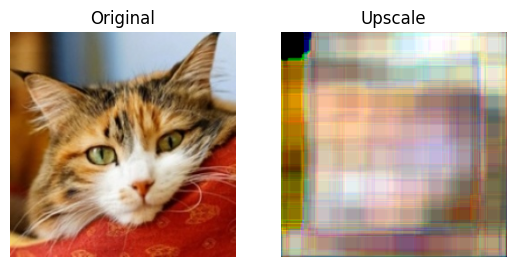

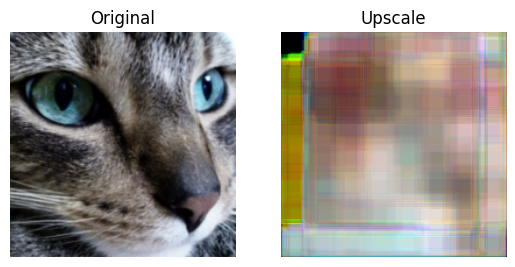

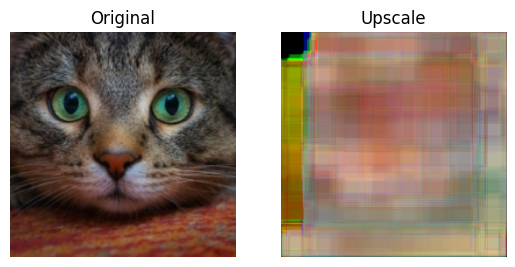

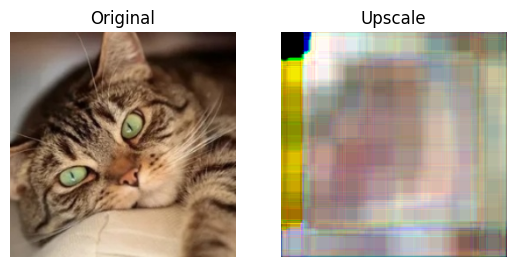

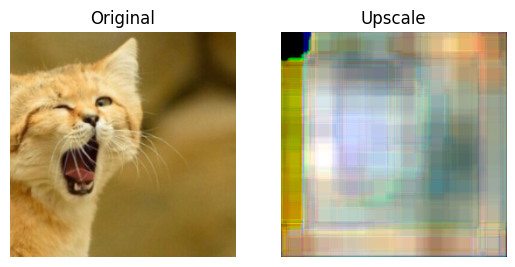

In [32]:
from imutils import paths
imagePaths = sorted(list(list_images(r"./test_images_2")))
for imagePath in imagePaths:
    predict(imagePath, autoencoder)